In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<IPython.core.display.Javascript object>

In [2]:
import os, shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


### TENSORBOARD WRITER

from datetime import datetime

DATA_ROOT_FOLDER = '/Users/brandon/Data/pytorch'

# run timestamp
ts = datetime.now().strftime('%Y%m%d_%H%M%S')

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'{DATA_ROOT_FOLDER}/runs/{ts}')


### DATA

# NOTE: train.zip > unzip, then in images dir (for ImageFolder dataset)
# mkdir cat; mkdir dog
# mv dog*.jpg dog; mv cat*.jpg cat

batch_size=32

transform = torchvision.transforms.Compose([
    transforms.Resize((150,150)),    
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

train_set = torchvision.datasets.ImageFolder(f'{DATA_ROOT_FOLDER}/data/DogsAndCats/train', transform=transform)
# dataset.class_to_idx
train_val_split = [0.7, 0.2, 0.1]
train_set, val_set, _ = utils.data.random_split(train_set, [round(p * len(train_set)) for p in train_val_split])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=4)


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 32, 3, padding = 1)       
        self.conv1_2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding = 1)        
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding = 1)        
        self.conv3_2 = nn.Conv2d(256, 512, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4_1 = nn.Conv2d(512, 512, 3, padding = 1)        
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding = 1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, dilation=2)
    
        self.dropout = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(512 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        out = x
        
        # handle single images
        if (len(out.shape) == 3):
            out = out.unsqueeze(0)
        
        out = F.relu(self.conv1_1(out))
        out = F.relu(self.conv1_2(out))
        out = self.pool1(out)

        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.pool2(out)
        
        out = F.relu(self.conv3_1(out))
        out = F.relu(self.conv3_2(out))
        out = self.pool3(out)
        
        out = F.relu(self.conv4_1(out))
        out = F.relu(self.conv4_2(out))
        out = self.pool4(out)
        
        out = self.dropout(out) 
        
        # flatten
        out = out.view(-1, 512 * 8 * 8)
        
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        # loss = BCEWithLogitsLoss
        #out = F.sigmoid(out)
        return out

    
model = Model()

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
model.to(device)
print(device)

loss_func = nn.BCEWithLogitsLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from torchinfo import summary
summary(model, input_size=(batch_size, 3, 150, 150), verbose=1, device=device)

num_epochs = 15
iter_count = 0
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    
    val_loss = 0.0
    val_acc = 0.0
    
    model.train()
    
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1:02d}')):
        iter_count += 1
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        
        labels = labels.unsqueeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        train_acc += torch.sum(torch.eq(outputs > 0, labels))
    
        # ...log the running loss
        if (i > 30) and not (i % 10):
            writer.add_scalar(f'Loss/train/{batch_size}',
                            train_loss / i / len(labels),
                            iter_count)

            writer.add_scalar(f'Accuracy/train/{batch_size}',
                            train_acc / i / len(labels),
                            iter_count)
        
    train_acc = train_acc.cpu().detach().numpy()
    train_loss = train_loss.cpu().detach().numpy()
    
    print('  * train  ' +
        f'Loss: {train_loss / len(train_loader.dataset):.4f}, ' +
        f'Accuracy: {100 * train_acc / len(train_loader.dataset):.3f}%, ' +
        f'LR: {optimizer.param_groups[0]["lr"]:.5f}')


    model.eval()
    for i, data in enumerate(val_loader, 0):
        with torch.no_grad():
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            labels = labels.unsqueeze(1)

            # forward
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
                
            val_loss += loss.data
            val_acc += torch.sum(torch.eq(outputs > 0, labels))
            
    print('  * val    ' +
        f'Loss: {val_loss / len(val_loader.dataset):.4f}, ' +
        f'Accuracy: {100 * val_acc / len(val_loader.dataset):.3f}%')

    writer.add_scalar('Loss/val',
                    val_loss / len(val_loader.dataset),
                    epoch+1)

    writer.add_scalar('Accuracy/val',
                    val_acc / len(val_loader.dataset),
                    epoch+1)

torch.save(model.state_dict(), f'{DATA_ROOT_FOLDER}/model/cats_and_dogs_small.pth')
#copy = torch.load('./model.pth');

mps
Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 1]                   --
├─Conv2d: 1-1                            [32, 32, 150, 150]        896
├─Conv2d: 1-2                            [32, 64, 150, 150]        18,496
├─MaxPool2d: 1-3                         [32, 64, 75, 75]          --
├─Conv2d: 1-4                            [32, 128, 75, 75]         73,856
├─Conv2d: 1-5                            [32, 128, 75, 75]         147,584
├─MaxPool2d: 1-6                         [32, 128, 37, 37]         --
├─Conv2d: 1-7                            [32, 256, 37, 37]         295,168
├─Conv2d: 1-8                            [32, 512, 37, 37]         1,180,160
├─MaxPool2d: 1-9                         [32, 512, 18, 18]         --
├─Conv2d: 1-10                           [32, 512, 18, 18]         2,359,808
├─Conv2d: 1-11                           [32, 512, 18, 18]         2,359,808
├─MaxPool2d: 1-12                        

/Users/brandon/anaconda3/envs/ee541_work/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/brandon/anaconda3/envs/ee541_work/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Epoch 01:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0215, Accuracy: 53.629%, LR: 0.00010
  * val    Loss: 0.0214, Accuracy: 56.080%


Epoch 02:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0208, Accuracy: 58.891%, LR: 0.00010
  * val    Loss: 0.0198, Accuracy: 65.460%


Epoch 03:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0182, Accuracy: 69.011%, LR: 0.00010
  * val    Loss: 0.0167, Accuracy: 73.480%


Epoch 04:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0157, Accuracy: 75.566%, LR: 0.00010
  * val    Loss: 0.0152, Accuracy: 76.380%


Epoch 05:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0138, Accuracy: 79.457%, LR: 0.00010
  * val    Loss: 0.0156, Accuracy: 76.520%


Epoch 06:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0121, Accuracy: 82.531%, LR: 0.00010
  * val    Loss: 0.0118, Accuracy: 82.860%


Epoch 07:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0108, Accuracy: 84.611%, LR: 0.00010
  * val    Loss: 0.0112, Accuracy: 84.640%


Epoch 08:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0099, Accuracy: 86.223%, LR: 0.00010
  * val    Loss: 0.0103, Accuracy: 86.140%


Epoch 09:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0091, Accuracy: 87.520%, LR: 0.00010
  * val    Loss: 0.0094, Accuracy: 87.700%


Epoch 10:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0083, Accuracy: 88.663%, LR: 0.00010
  * val    Loss: 0.0086, Accuracy: 88.740%


Epoch 11:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0076, Accuracy: 89.749%, LR: 0.00010
  * val    Loss: 0.0084, Accuracy: 88.720%


Epoch 12:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0070, Accuracy: 90.686%, LR: 0.00010
  * val    Loss: 0.0076, Accuracy: 89.520%


Epoch 13:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0065, Accuracy: 91.354%, LR: 0.00010
  * val    Loss: 0.0068, Accuracy: 91.420%


Epoch 14:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0061, Accuracy: 92.040%, LR: 0.00010
  * val    Loss: 0.0073, Accuracy: 90.780%


Epoch 15:   0%|          | 0/547 [00:00<?, ?it/s]

  * train  Loss: 0.0058, Accuracy: 92.463%, LR: 0.00010
  * val    Loss: 0.0077, Accuracy: 90.600%


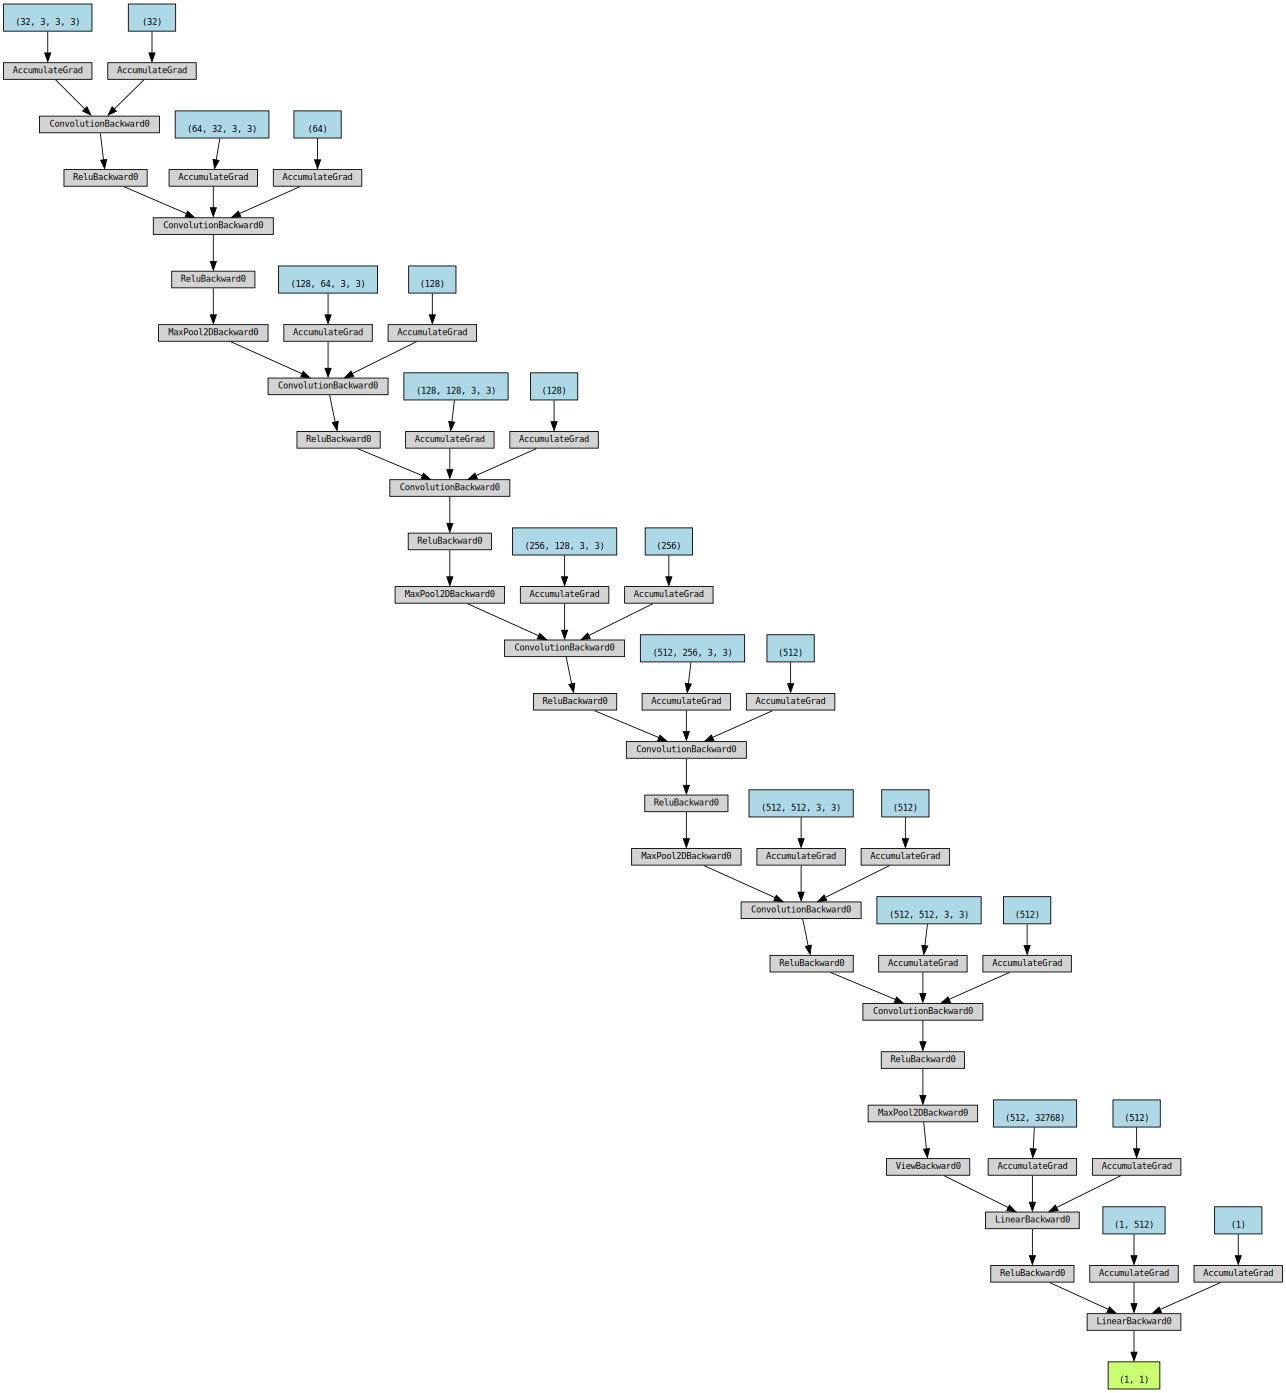

In [3]:
# requires GraphViz
# https://graphviz.org/download/

from torchviz import make_dot

y, label = next(iter(train_set))
y = y.to(device)

output = model(y)

make_dot(output)